This notebook is designed to demonstrate how to produce plots for airborne EM (line data), borehole variables (point data) and mapped products on a vertical section.

Neil Symington neil.symington@ga.gov.au

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from geophys_utils._transect_utils import coords2distance
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import hydrogeol_utils.plotting_utils as plot_utils
import os, glob
import math
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
import rasterio

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def point_within_bounds(point, bounds):
    [x,y] = point
    
    if (bounds.left < x) & (bounds.right > x):
        if (bounds.bottom < y) & (bounds.top > y):
            return True
    return False

def sample_raster_along_line(coords, raster, null = -3.4028235e+38):
    """
    A function for sampling a raster on a set of coordinates
    """
    # Get the bounds of the raster
    raster_bounds = raster.bounds
    
    # Create array for sampled values
    sampled_array = np.nan*np.ones(shape = len(coords),
                                   dtype = np.float32)
    
    # Create generator for sampling the raster
    
    for i, point in enumerate(coords):
        
        if point_within_bounds(point, raster_bounds):
        
            val = next(raster.sample(np.expand_dims(point, axis=0)))[0]
            
            # If the value is not a null
            if not val < -900:# Adhoc fix due to floating point errors
            #if not val == null:
                
                sampled_array[i] = val
    return sampled_array

In [3]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf'

# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'OrdKeep2019_DataResp_cor2DLogOrd.nc')
EM_dataset = netCDF4.Dataset(EM_path)


# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdKeep2019_ModeExp_cor2DLogOrd.nc')
cond_dataset = netCDF4.Dataset(cond_path)


In [5]:
lines = [308102,
308601,
308901,
309301,
309701,
310001,
310301,
313001,
315401,
319401,
319901,
320401,
323301,
323701,
805900,
806102,
806201,
806602
]

In [6]:
# Create an instance of plots for gridding the data
plots = plot_utils.ConductivitySectionPlot(cond_dataset, EM_dataset)

# Define some key variables which we want to inteprolate

plots.conductivity_variables = ['conductivity', 'data_residual', 'tx_height_measured', 'depth_of_investigation']

plots.EM_varibles  = ['data_values_by_low_moment_gate', 'data_values_by_high_moment_gate', 
                       'data_response_by_low_moment_gate', 'data_response_by_high_moment_gate']


# Define the resolution of th sections
xres, yres = 10., 3.

In [7]:
# Grid the line but leave it in memory
gridded_variables = plots.grid_variables(xres = xres, yres =yres, lines=list(lines), resampling_method = 'linear',
                                         save_hdf5 = False, return_dict = True)

In [8]:
# Bring in the induction data from spatialite database to pandas dataframe

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

connection = engine.connect()

query = '''SELECT

            b.*,
            const.Depth_to
            
FROM 

        borehole b
        JOIN borehole_construction as const on b.borehole_id=const.borehole_id;'''

df_header = pd.read_sql_query(query, connection)


In [9]:
df_header.columns

Index(['borehole_id', 'Borehole_name', 'Alternative_name', 'Easting',
       'Northing', 'Ground_elevation_mAHD', 'Induction_acquired',
       'Gamma_acquired', 'Javelin_acquired', 'Hylogger_acquired_on_core',
       'Hylogger_acquired_on_chips', 'Lithology_available', 'EC_pH_acquired',
       'SWL_available', 'Construction_available', 'MagSus_available',
       'AEM_conductivity_available', 'geometry', 'geom', 'Depth_to'],
      dtype='object')

In [10]:
# Now keep only the largest value to have max depth

cols = ['borehole_id', 'Borehole_name', 'Easting',
       'Northing', 'Ground_elevation_mAHD', 'Depth_to']

df_bores = df_header[cols].groupby(by = 'Borehole_name').max()

df_bores = df_bores.rename(columns = {'Depth_to': 'max_depth'})

In [11]:
# For every bore we will find the distance and netcdf
# index for each borehole that is within 500 m of an AEM fiducial

enos = []

for line in lines:

    aem_coords = np.hstack((gridded_variables[line]['easting'].reshape([-1,1]),
                            gridded_variables[line]['northing'].reshape([-1,1])))


    distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']], aem_coords,
                                                            points_required = 1, max_distance = 500.)
    
    for i, (index, row) in enumerate(df_header.iterrows()):
        # If the distances are not infinite (i.e. the boreholes disatnce is greater
        # than the maximum)
        if np.isfinite(np.sum(distances[i])):
            # Append the borehole id so we can extract it at a later time
            enos.append(row.borehole_id)
    
    

In [12]:
df_bores

,borehole_id,Easting,Northing,Ground_elevation_mAHD,max_depth
Borehole_name,,,,,
IP02,635920,441693.000,8289537.000,5.800,11.0
KR54,635747,467010.637,8305925.689,47.398,41.0
KR55,635748,462063.182,8304333.873,49.364,32.0
KR58,635749,432985.000,8287369.000,5.900,29.0
RN039888,628981,468836.000,8331457.000,92.860,301.6
RN039889,635922,473913.000,8333234.000,84.052,302.0
RN039890,635923,479026.000,8334987.000,41.337,250.0
RN039891,635750,464530.000,8306159.000,47.791,150.0
RN040780,635744,530338.125,8322496.983,5.094,147.0


In [13]:
# Get the points from a csv file

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\stratigraphy\base_of_cenozoic_points.csv"

df_ceno = pd.read_csv(infile)

df_ceno = df_ceno[pd.notnull(df_ceno['borehole_id'])]

df_ceno

# Get the elevation from df_header

df_ = df_bores[df_bores['borehole_id'].isin(df_ceno['borehole_id'].values)]

df_merged = df_.merge(df_ceno[['base_of_cenozoic_depth', 'borehole_id']], on = 'borehole_id')

In [14]:
df_merged['base_cenozoic_elevation'] = df_merged['Ground_elevation_mAHD'] - df_merged['base_of_cenozoic_depth']
df_merged['min_elevation'] = df_merged['Ground_elevation_mAHD'] - df_merged['max_depth']

In [15]:
# Create a dataframe with basement vs cenozoic

df_strat = pd.DataFrame(columns = ['borehole_id', 'Easting', 'Northing', 'Elevation_from', 'Elevation_to'])

for index, row in df_merged.iterrows():
    # Entry for cenozoic
    df_temp = pd.DataFrame({'borehole_id': 2*[row.borehole_id], 'Easting': 2*[row.Easting],
                            'Northing': 2*[row.Northing],
                           'Elevation_from': [row.Ground_elevation_mAHD,row.base_cenozoic_elevation],
                           'Elevation_to': [row.base_cenozoic_elevation, row.min_elevation],
                                            'stratigraphy': ['cenozoic', 'basement'],
                                            'label': [0,1]})
    df_strat =df_strat.append(df_temp)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [16]:
df_strat

,Easting,Elevation_from,Elevation_to,Northing,borehole_id,label,stratigraphy
0,523321.548,4.735,-11.825,8314868.930,635921.0,0.0,cenozoic
1,523321.548,-11.825,-145.265,8314868.930,635921.0,1.0,basement
0,542730.465,5.055,-48.325,8331303.544,635746.0,0.0,cenozoic
1,542730.465,-48.325,-95.945,8331303.544,635746.0,1.0,basement
0,530360.114,4.799,-33.381,8322488.629,635743.0,0.0,cenozoic
1,530360.114,-33.381,-42.401,8322488.629,635743.0,1.0,basement
0,520144.760,7.519,-32.771,8306293.880,635728.0,0.0,cenozoic
1,520144.760,-32.771,-34.481,8306293.880,635728.0,1.0,basement
0,501830.614,17.506,-16.684,8295403.070,635733.0,0.0,cenozoic
1,501830.614,-16.684,-19.194,8295403.070,635733.0,1.0,basement


In [16]:
# Now we want to add the gridded data to the section plot

water_table = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\raster_elevation_interpolation\nulled\KeepRiver_waterTable_mAHD.tif"
base_ceno = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\AEM_interp_OrdKeep\Neil\elevatoin\Cz_base.tif"
top_mill = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\AEM_interp_OrdKeep\Neil\elevatoin\Clm_top.tif"

In [17]:
# Open the tif files
wt_src = rasterio.open(water_table)

ceno_src = rasterio.open(base_ceno)

mill_src = rasterio.open(top_mill)


In [18]:
def add_stratigraphic_sticks(ax, df, gridded_variables, strat_column, xy_columns, colour_mapping = None,
                             max_distance=200., stick_thickness=150.):

    # Get the coordinates of the section
    utm_coords = np.hstack((gridded_variables['easting'].reshape([-1, 1]),
                            gridded_variables['northing'].reshape([-1, 1])))

    # Find the nearest neighbours within the maximum distance
    d, i = spatial_functions.nearest_neighbours(df[xy_columns].values,
                                               utm_coords,
                                               points_required=1,
                                               max_distance=max_distance)

    # Add the minimum distance to the dataframe and remove nulls (i.e. those
    # that have a distance greater than the maximum allowable as denoted by a value
    # that is greater thant the length of the xy coordinates
    df['min_index'] = i

    df = df[df['min_index'] < len(utm_coords)]

    # Create an elevation from, to and distance along the line using the elevation and
    # distance along the line of the nearest neighbour

    df.loc[:, 'dist_along_line'] = gridded_variables['grid_distances'][df['min_index']]

    # Now we will define the colour stretch for water content based on the plasma colourbar


    # Iterate through the elevation intervls and add them to the axis
    for index, row in df.iterrows():
        strat = row[strat_column]
        # Define variables from the dataframe row
        elevation_from = row['Elevation_from']
        thickness = row['Elevation_to'] - elevation_from
        distance_along_line = row['dist_along_line']
        # Add them to the axis
        rect = Rectangle((distance_along_line, elevation_from), stick_thickness, thickness,
                         edgecolor='k', facecolor=colour_mapping[strat])
        ax.add_patch(rect)

In [19]:
# Iteratively do all lines with the same settings

plot_settings = {'figsize': (30, 10), 'dpi': 350}

panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 250, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4},
                  
                 'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 250, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.005, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4}
                 }



for line in lines:
    
    plt.close()

    fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 6), sharex = True,
                                         gridspec_kw={'height_ratios':
                                                      plot_utils.unpack_plot_settings(panel_settings,
                                                                                      'height_ratio')})
    
    
    
    plot_utils.plot_conductivity_section(ax_array, gridded_variables[line],
                                         plot_settings, panel_settings,
                                         save_fig = False)
    
    
    for bore in df_merged['borehole_id'].unique():
        
        mask = (df_strat['borehole_id'] == bore)
    
        for ax in ax_array[1:]:
    
            add_stratigraphic_sticks(ax, df_strat[mask], gridded_variables[line],
                                 'stratigraphy', ['Easting', 'Northing'],
                                 colour_mapping = {'cenozoic': 'yellow',
                                                  'basement': 'green'},
                                 max_distance=200., stick_thickness=300.)

    
    ax_array[2].set_title("OrdKeep2019_ModelExp_cord2dLogKeep - " + str(line) + ' log plot')
    
    ax_array[1].set_title("OrdKeep2019_ModelExp_cord2dLogKeep - " + str(line)  + ' linear plot' )

    ax_array[0].set_title("Data residual - " + str(line))

    # Sample the water table and plot it on the map

    #utm_coords = np.hstack((gridded_variables[line]['easting'].reshape([-1,1]),
    #                        gridded_variables[line]['northing'].reshape([-1,1])))

    #wt_sampled = sample_raster_along_line(utm_coords, wt_src)

    #base_ceno_sampled = sample_raster_along_line(utm_coords, ceno_src)

    #top_milligans = sample_raster_along_line(utm_coords, mill_src)

    #for ax in ax_array[1:]:
    #    ax.plot(gridded_variables[line]['grid_distances'],
    #                   base_ceno_sampled, 'k', linewidth=3,
    #           label = 'Base of cenozoic')
   # 
    #    ax.plot(gridded_variables[line]['grid_distances'],
    #                   top_milligans, 'green', linewidth=3,
    #           label = 'Top of milligans')

    ax_pos = plot_utils.align_axes(ax_array)

    # Add axis with northing at the bottom of the plot

    outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Gibbo\AEM_sections"
    outfile = os.path.join(outdir, str(line) + ".png")

    #ax.legend()
    
    
    plt.savefig(outfile, dpi=350, bbox_inches="tight")

    

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No 

In [22]:
dir(fig)

['_Figure__remove_ax',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_contains',
 '_dpi',
 '_gci',
 '_get_axes',
 '_get_dpi',
 '_gid',
 '_hold',
 '_label',
 '_make_key',
 '_mouseover',
 '_oid',
 '_path_effects',
 '_picker',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_repr_html_',
 '_set_artist_props',
 '_set_dpi',
 '_set_gc_clip',
 '_sketch',
 '_snap',
 '_stale',
 '_sticky_edges',
 '_suptitle',
 '_tight',
 '_tight_parameters',
 '_transform',
 '_transformSet',
 '_url',
 '_visible',
 'add_ax

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


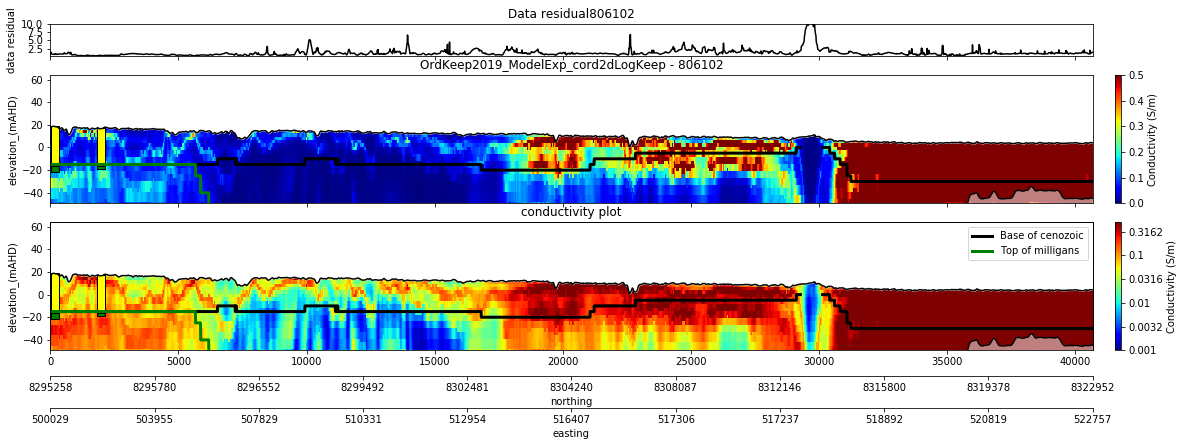

In [89]:
# Otherwise for complete control use a cell for each line
# Plot sections

line = lines[0]

plot_settings = {'figsize': (40, 10), 'dpi': 350}

panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4},
                  
                 'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4}
                 }



plt.close()

fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 6), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,
                                                                                  'height_ratio')})



plot_utils.plot_conductivity_section(ax_array, gridded_variables[line], plot_settings, panel_settings, save_fig = False)


for bore in df_merged['borehole_id'].unique():
    
    mask = (df_strat['borehole_id'] == bore)
    
    for ax in ax_array[1:]:
    
        add_stratigraphic_sticks(ax, df_strat[mask], gridded_variables[line],
                             'stratigraphy', ['Easting', 'Northing'],
                             colour_mapping = {'cenozoic': 'yellow',
                                              'basement': 'green'},
                             max_distance=200., stick_thickness=300.)

    
ax_array[1].set_title("OrdKeep2019_ModelExp_cord2dLogKeep - " + str(line))

ax_array[0].set_title("Data residual" + str(line))

# Sample the water table and plot it on the map

utm_coords = np.hstack((gridded_variables[line]['easting'].reshape([-1,1]),
                        gridded_variables[line]['northing'].reshape([-1,1])))

wt_sampled = sample_raster_along_line(utm_coords, wt_src)

base_ceno_sampled = sample_raster_along_line(utm_coords, ceno_src)

top_milligans = sample_raster_along_line(utm_coords, mill_src)

for ax in ax_array[1:]:
    ax.plot(gridded_variables[line]['grid_distances'],
                   base_ceno_sampled, 'k', linewidth=3,
           label = 'Base of cenozoic')
    
    ax.plot(gridded_variables[line]['grid_distances'],
                   top_milligans, 'green', linewidth=3,
           label = 'Top of milligans')

ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KP_interp_AEM_sections"
outfile = os.path.join(outdir, str(line) + ".png")

ax.legend()
plt.savefig(outfile, dpi=350)

plt.show()

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


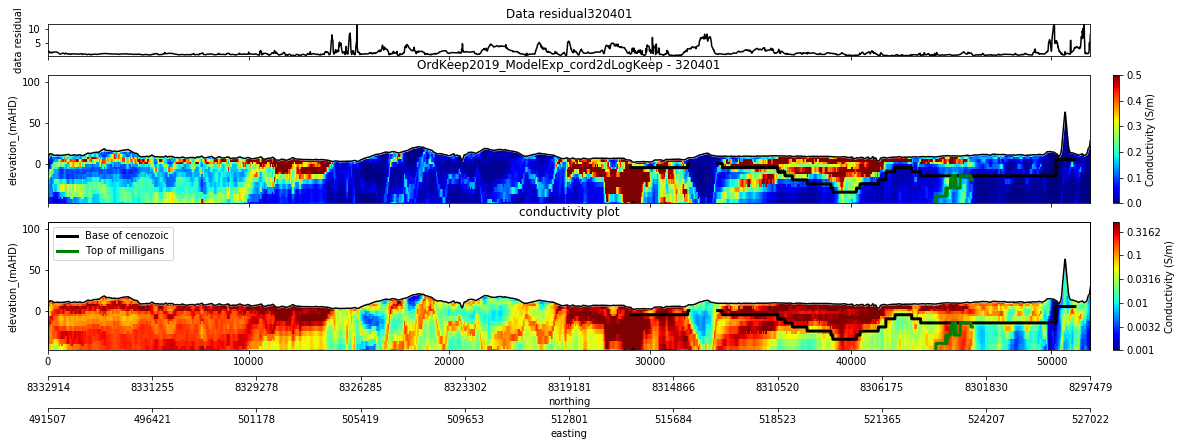

In [90]:
# Plot sections

line = lines[1]

plot_settings = {'figsize': (40, 10), 'dpi': 350}

panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4},
                  
                 'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4}
                 }



plt.close()

fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 6), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,
                                                                                  'height_ratio')})



plot_utils.plot_conductivity_section(ax_array, gridded_variables[line], plot_settings, panel_settings, save_fig = False)


for bore in df_merged['borehole_id'].unique():
    
    mask = (df_strat['borehole_id'] == bore)
    
    for ax in ax_array[1:]:
    
        add_stratigraphic_sticks(ax, df_strat[mask], gridded_variables[line],
                             'stratigraphy', ['Easting', 'Northing'],
                             colour_mapping = {'cenozoic': 'yellow',
                                              'basement': 'green'},
                             max_distance=200., stick_thickness=300.)

    
ax_array[1].set_title("OrdKeep2019_ModelExp_cord2dLogKeep - " + str(line))

ax_array[0].set_title("Data residual" + str(line))

# Sample the water table and plot it on the map

utm_coords = np.hstack((gridded_variables[line]['easting'].reshape([-1,1]),
                        gridded_variables[line]['northing'].reshape([-1,1])))

wt_sampled = sample_raster_along_line(utm_coords, wt_src)

base_ceno_sampled = sample_raster_along_line(utm_coords, ceno_src)

top_milligans = sample_raster_along_line(utm_coords, mill_src)

for ax in ax_array[1:]:
    ax.plot(gridded_variables[line]['grid_distances'],
                   base_ceno_sampled, 'k', linewidth=3,
           label = 'Base of cenozoic')
    
    ax.plot(gridded_variables[line]['grid_distances'],
                   top_milligans, 'green', linewidth=3,
           label = 'Top of milligans')

ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KP_interp_AEM_sections"
outfile = os.path.join(outdir, str(line) + ".png")

ax.legend()
plt.savefig(outfile, dpi=350)

plt.show()

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


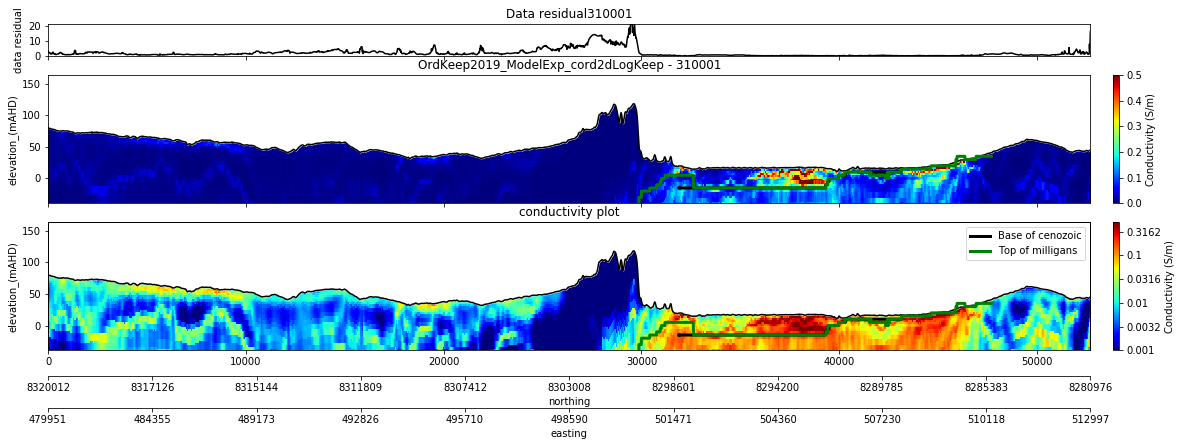

In [93]:
# Plot sections

line = lines[2]

plot_settings = {'figsize': (40, 10), 'dpi': 350}

panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4},
                  
                 'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4}
                 }



plt.close()

fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 6), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,
                                                                                  'height_ratio')})



plot_utils.plot_conductivity_section(ax_array, gridded_variables[line], plot_settings, panel_settings, save_fig = False)


for bore in df_merged['borehole_id'].unique():
    
    mask = (df_strat['borehole_id'] == bore)
    
    for ax in ax_array[1:]:
    
        add_stratigraphic_sticks(ax, df_strat[mask], gridded_variables[line],
                             'stratigraphy', ['Easting', 'Northing'],
                             colour_mapping = {'cenozoic': 'yellow',
                                              'basement': 'green'},
                             max_distance=200., stick_thickness=300.)

    
ax_array[1].set_title("OrdKeep2019_ModelExp_cord2dLogKeep - " + str(line))

ax_array[0].set_title("Data residual" + str(line))

# Sample the water table and plot it on the map

utm_coords = np.hstack((gridded_variables[line]['easting'].reshape([-1,1]),
                        gridded_variables[line]['northing'].reshape([-1,1])))

wt_sampled = sample_raster_along_line(utm_coords, wt_src)

base_ceno_sampled = sample_raster_along_line(utm_coords, ceno_src)

top_milligans = sample_raster_along_line(utm_coords, mill_src)

for ax in ax_array[1:]:
    ax.plot(gridded_variables[line]['grid_distances'],
                   base_ceno_sampled, 'k', linewidth=3,
           label = 'Base of cenozoic')
    
    ax.plot(gridded_variables[line]['grid_distances'],
                   top_milligans, 'green', linewidth=3,
           label = 'Top of milligans')

ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KP_interp_AEM_sections"
outfile = os.path.join(outdir, str(line) + ".png")

ax.legend()
plt.savefig(outfile, dpi=350)

plt.show()

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


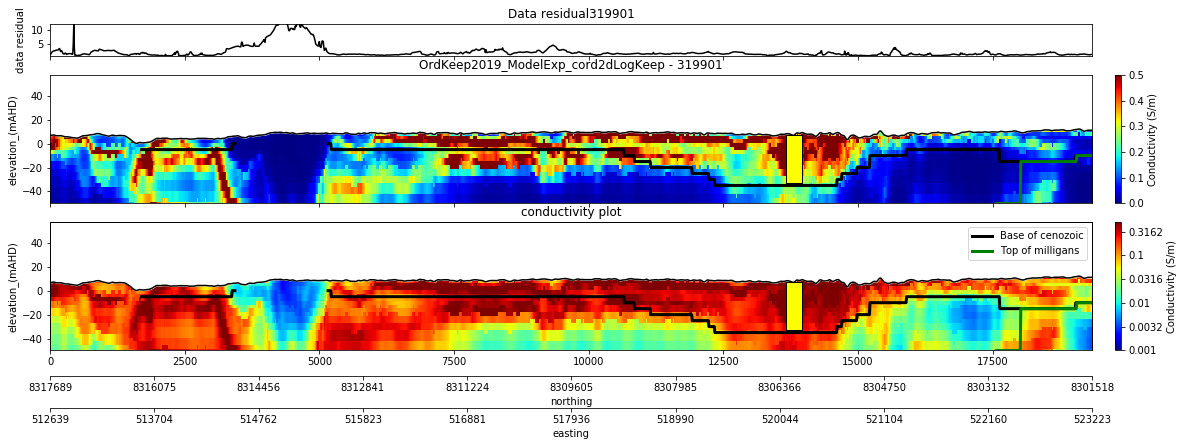

In [91]:
# Plot sections

line = lines[3]

plot_settings = {'figsize': (40, 10), 'dpi': 350}

panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4},
                  
                 'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4}
                 }



plt.close()

fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 6), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,
                                                                                  'height_ratio')})



plot_utils.plot_conductivity_section(ax_array, gridded_variables[line], plot_settings, panel_settings, save_fig = False)


for bore in df_merged['borehole_id'].unique():
    
    mask = (df_strat['borehole_id'] == bore)
    
    for ax in ax_array[1:]:
    
        add_stratigraphic_sticks(ax, df_strat[mask], gridded_variables[line],
                             'stratigraphy', ['Easting', 'Northing'],
                             colour_mapping = {'cenozoic': 'yellow',
                                              'basement': 'green'},
                             max_distance=200., stick_thickness=300.)

    
ax_array[1].set_title("OrdKeep2019_ModelExp_cord2dLogKeep - " + str(line))

ax_array[0].set_title("Data residual" + str(line))

# Sample the water table and plot it on the map

utm_coords = np.hstack((gridded_variables[line]['easting'].reshape([-1,1]),
                        gridded_variables[line]['northing'].reshape([-1,1])))

wt_sampled = sample_raster_along_line(utm_coords, wt_src)

base_ceno_sampled = sample_raster_along_line(utm_coords, ceno_src)

top_milligans = sample_raster_along_line(utm_coords, mill_src)

for ax in ax_array[1:]:
    ax.plot(gridded_variables[line]['grid_distances'],
                   base_ceno_sampled, 'k', linewidth=3,
           label = 'Base of cenozoic')
    
    ax.plot(gridded_variables[line]['grid_distances'],
                   top_milligans, 'green', linewidth=3,
           label = 'Top of milligans')

ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KP_interp_AEM_sections"
outfile = os.path.join(outdir, str(line) + ".png")

ax.legend()
plt.savefig(outfile, dpi=350)

plt.show()

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


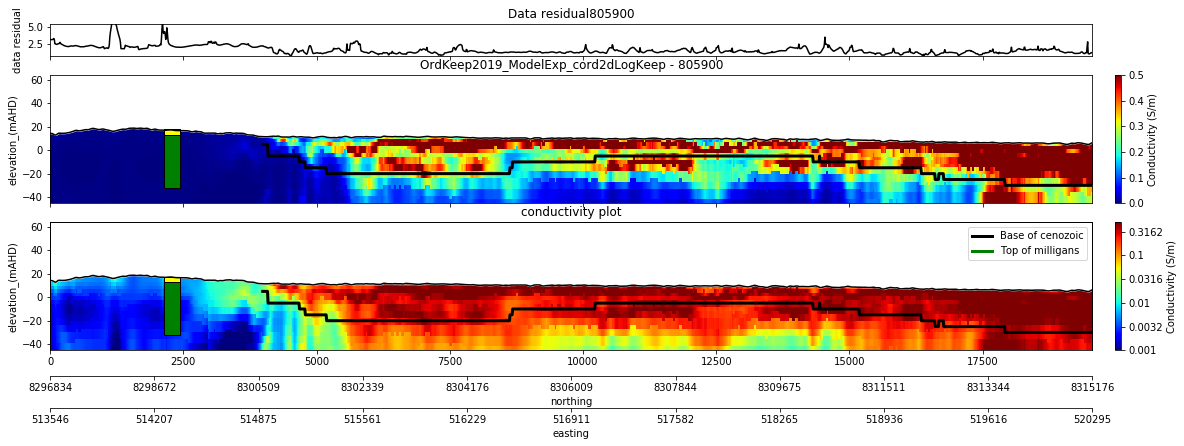

In [92]:
# Plot sections

line = lines[4]

plot_settings = {'figsize': (40, 10), 'dpi': 350}

plot_settings = {'figsize': (40, 10), 'dpi': 350}

panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4},
                  
                 'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 50, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4}
                 }



plt.close()

fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 6), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,
                                                                                  'height_ratio')})



plot_utils.plot_conductivity_section(ax_array, gridded_variables[line], plot_settings, panel_settings, save_fig = False)


for bore in df_merged['borehole_id'].unique():
    
    mask = (df_strat['borehole_id'] == bore)
    
    for ax in ax_array[1:]:
    
        add_stratigraphic_sticks(ax, df_strat[mask], gridded_variables[line],
                             'stratigraphy', ['Easting', 'Northing'],
                             colour_mapping = {'cenozoic': 'yellow',
                                              'basement': 'green'},
                             max_distance=200., stick_thickness=300.)

    
ax_array[1].set_title("OrdKeep2019_ModelExp_cord2dLogKeep - " + str(line))

ax_array[0].set_title("Data residual" + str(line))

# Sample the water table and plot it on the map

utm_coords = np.hstack((gridded_variables[line]['easting'].reshape([-1,1]),
                        gridded_variables[line]['northing'].reshape([-1,1])))

wt_sampled = sample_raster_along_line(utm_coords, wt_src)

base_ceno_sampled = sample_raster_along_line(utm_coords, ceno_src)

top_milligans = sample_raster_along_line(utm_coords, mill_src)

for ax in ax_array[1:]:
    ax.plot(gridded_variables[line]['grid_distances'],
                   base_ceno_sampled, 'k', linewidth=3,
           label = 'Base of cenozoic')
    
    ax.plot(gridded_variables[line]['grid_distances'],
                   top_milligans, 'green', linewidth=3,
           label = 'Top of milligans')

ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KP_interp_AEM_sections"
outfile = os.path.join(outdir, str(line) + ".png")

ax.legend()
plt.savefig(outfile, dpi=350)

plt.show()